In [11]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path)).convert('RGB')

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(coco_annotation[i]["category_id"])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [13]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

train_data_dir = 'images'
train_coco = 'annotations/instances_default.json'

# create own Dataset
my_dataset = myOwnDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [14]:
len(my_dataset)

6

In [22]:
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 2

# own DataLoader
data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn)

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [30]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np


def create_model(num_classes, pretrained=False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


# 35 classes; Only target class or background
num_classes = 36
num_epochs = 1000
model = create_model(num_classes)
model.to(device)

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0
    loss = []
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())
        loss.append(losses.cpu().detach().numpy())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    loss = np.array(loss).mean()
    if epoch % 100 == 0:
      torch.save(model.state_dict(), f'models/epoch_{epoch}_{loss}.pth')
    print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}, mean_loss: {loss}')

c:\users\igorc\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\users\igorc\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Iteration: 3/3, Loss: 2.5897490978240967, mean_loss: 3.6574888229370117
Iteration: 3/3, Loss: 2.265446186065674, mean_loss: 1.7728142738342285
Iteration: 3/3, Loss: 1.904363751411438, mean_loss: 2.288804531097412
Iteration: 3/3, Loss: 1.2790453433990479, mean_loss: 1.9774144887924194
Iteration: 3/3, Loss: 1.1153992414474487, mean_loss: 1.8732891082763672
Iteration: 3/3, Loss: 1.011630892753601, mean_loss: 1.845110297203064
Iteration: 3/3, Loss: 1.8852955102920532, mean_loss: 1.7942358255386353
Iteration: 3/3, Loss: 1.7340834140777588, mean_loss: 1.9095721244812012
Iteration: 3/3, Loss: 1.9710707664489746, mean_loss: 1.9341415166854858
Iteration: 3/3, Loss: 1.5002176761627197, mean_loss: 1.7600024938583374
Iteration: 3/3, Loss: 2.057600975036621, mean_loss: 1.696027159690857
Iteration: 3/3, Loss: 2.018479585647583, mean_loss: 1.7141116857528687
Iteration: 3/3, Loss: 1.9912809133529663, mean_loss: 1.624409556388855
Iteration: 3/3, Loss: 2.0107314586639404, mean_loss: 1.4989118576049805
I

Iteration: 3/3, Loss: 0.1370168924331665, mean_loss: 0.16382503509521484
Iteration: 3/3, Loss: 0.11650034040212631, mean_loss: 0.17302559316158295
Iteration: 3/3, Loss: 0.12677286565303802, mean_loss: 0.1283087581396103
Iteration: 3/3, Loss: 0.20332787930965424, mean_loss: 0.15941636264324188
Iteration: 3/3, Loss: 0.17178794741630554, mean_loss: 0.15876661241054535
Iteration: 3/3, Loss: 0.2484295517206192, mean_loss: 0.18037427961826324
Iteration: 3/3, Loss: 0.1962020844221115, mean_loss: 0.1890946477651596
Iteration: 3/3, Loss: 0.1517695188522339, mean_loss: 0.16278374195098877
Iteration: 3/3, Loss: 0.1006251871585846, mean_loss: 0.14084644615650177
Iteration: 3/3, Loss: 0.1380881816148758, mean_loss: 0.16263359785079956
Iteration: 3/3, Loss: 0.20096410810947418, mean_loss: 0.192620649933815
Iteration: 3/3, Loss: 0.20058810710906982, mean_loss: 0.17175334692001343
Iteration: 3/3, Loss: 0.202351376414299, mean_loss: 0.16380997002124786
Iteration: 3/3, Loss: 0.11614933609962463, mean_lo

Iteration: 3/3, Loss: 0.13483926653862, mean_loss: 0.12071927636861801
Iteration: 3/3, Loss: 0.09391481429338455, mean_loss: 0.09713700413703918
Iteration: 3/3, Loss: 0.07712164521217346, mean_loss: 0.09754066914319992
Iteration: 3/3, Loss: 0.06692755967378616, mean_loss: 0.09881698340177536
Iteration: 3/3, Loss: 0.14214995503425598, mean_loss: 0.0991673469543457
Iteration: 3/3, Loss: 0.06761091947555542, mean_loss: 0.09778404235839844
Iteration: 3/3, Loss: 0.13262872397899628, mean_loss: 0.09107989072799683
Iteration: 3/3, Loss: 0.11146045476198196, mean_loss: 0.09598638862371445
Iteration: 3/3, Loss: 0.07449086010456085, mean_loss: 0.09411820024251938
Iteration: 3/3, Loss: 0.08838943392038345, mean_loss: 0.08401902765035629
Iteration: 3/3, Loss: 0.07945279777050018, mean_loss: 0.08504702895879745
Iteration: 3/3, Loss: 0.07476627081632614, mean_loss: 0.07970631867647171
Iteration: 3/3, Loss: 0.08198067545890808, mean_loss: 0.07315511256456375
Iteration: 3/3, Loss: 0.11643197387456894,

Iteration: 3/3, Loss: 0.10324237495660782, mean_loss: 0.0936754047870636
Iteration: 3/3, Loss: 0.07513086497783661, mean_loss: 0.07392065972089767
Iteration: 3/3, Loss: 0.08494394272565842, mean_loss: 0.07018759846687317
Iteration: 3/3, Loss: 0.05701994523406029, mean_loss: 0.06968774646520615
Iteration: 3/3, Loss: 0.07113814353942871, mean_loss: 0.06476154178380966
Iteration: 3/3, Loss: 0.07021854817867279, mean_loss: 0.06360193341970444
Iteration: 3/3, Loss: 0.06404566019773483, mean_loss: 0.058019328862428665
Iteration: 3/3, Loss: 0.05304494872689247, mean_loss: 0.050306644290685654
Iteration: 3/3, Loss: 0.04181281104683876, mean_loss: 0.0622197687625885
Iteration: 3/3, Loss: 0.054630495607852936, mean_loss: 0.05615346133708954
Iteration: 3/3, Loss: 0.05809158831834793, mean_loss: 0.05476822331547737
Iteration: 3/3, Loss: 0.04745851457118988, mean_loss: 0.05594697967171669
Iteration: 3/3, Loss: 0.06387466937303543, mean_loss: 0.0573284737765789
Iteration: 3/3, Loss: 0.06132684275507

Iteration: 3/3, Loss: 0.056148793548345566, mean_loss: 0.04942430555820465
Iteration: 3/3, Loss: 0.05985695868730545, mean_loss: 0.052883803844451904
Iteration: 3/3, Loss: 0.08146537095308304, mean_loss: 0.06463197618722916
Iteration: 3/3, Loss: 0.059146732091903687, mean_loss: 0.06507212668657303
Iteration: 3/3, Loss: 0.0765218734741211, mean_loss: 0.06103747710585594
Iteration: 3/3, Loss: 0.04932360351085663, mean_loss: 0.06777962297201157
Iteration: 3/3, Loss: 0.06676691025495529, mean_loss: 0.0675613060593605
Iteration: 3/3, Loss: 0.09438402205705643, mean_loss: 0.07331207394599915
Iteration: 3/3, Loss: 0.07668148726224899, mean_loss: 0.06316763162612915
Iteration: 3/3, Loss: 0.06032399460673332, mean_loss: 0.05528770759701729
Iteration: 3/3, Loss: 0.0646805465221405, mean_loss: 0.0625520572066307
Iteration: 3/3, Loss: 0.06366016715765, mean_loss: 0.08018430322408676
Iteration: 3/3, Loss: 0.08286338299512863, mean_loss: 0.06666489690542221
Iteration: 3/3, Loss: 0.09467445313930511,

Iteration: 3/3, Loss: 0.0348476767539978, mean_loss: 0.03922341763973236
Iteration: 3/3, Loss: 0.040063053369522095, mean_loss: 0.03416392579674721
Iteration: 3/3, Loss: 0.03962187469005585, mean_loss: 0.03618447855114937
Iteration: 3/3, Loss: 0.03319702297449112, mean_loss: 0.02949686348438263
Iteration: 3/3, Loss: 0.056154776364564896, mean_loss: 0.04392899200320244
Iteration: 3/3, Loss: 0.05279405787587166, mean_loss: 0.03829658403992653
Iteration: 3/3, Loss: 0.04423981159925461, mean_loss: 0.051853250712156296
Iteration: 3/3, Loss: 0.06168988719582558, mean_loss: 0.05488777533173561
Iteration: 3/3, Loss: 0.0474865585565567, mean_loss: 0.04750192537903786
Iteration: 3/3, Loss: 0.054119933396577835, mean_loss: 0.05391380190849304
Iteration: 3/3, Loss: 0.03399324044585228, mean_loss: 0.047237034887075424
Iteration: 3/3, Loss: 0.06470635533332825, mean_loss: 0.053001631051301956
Iteration: 3/3, Loss: 0.05959118530154228, mean_loss: 0.047922130674123764
Iteration: 3/3, Loss: 0.052383884

Iteration: 3/3, Loss: 0.028774887323379517, mean_loss: 0.037292689085006714
Iteration: 3/3, Loss: 0.030257485806941986, mean_loss: 0.03269160911440849
Iteration: 3/3, Loss: 0.027515752241015434, mean_loss: 0.03632553294301033
Iteration: 3/3, Loss: 0.02808747999370098, mean_loss: 0.038428571075201035
Iteration: 3/3, Loss: 0.03404935076832771, mean_loss: 0.030809292569756508
Iteration: 3/3, Loss: 0.043819863349199295, mean_loss: 0.03414583578705788
Iteration: 3/3, Loss: 0.03175345063209534, mean_loss: 0.026070529595017433
Iteration: 3/3, Loss: 0.02167419344186783, mean_loss: 0.027864135801792145
Iteration: 3/3, Loss: 0.024626607075333595, mean_loss: 0.030868493020534515
Iteration: 3/3, Loss: 0.024322515353560448, mean_loss: 0.028715254738926888
Iteration: 3/3, Loss: 0.01591569185256958, mean_loss: 0.026273885741829872
Iteration: 3/3, Loss: 0.020967690274119377, mean_loss: 0.029800178483128548
Iteration: 3/3, Loss: 0.023872725665569305, mean_loss: 0.023314660415053368
Iteration: 3/3, Loss

Iteration: 3/3, Loss: 0.03677753731608391, mean_loss: 0.0343787707388401
Iteration: 3/3, Loss: 0.0489119328558445, mean_loss: 0.03468327596783638
Iteration: 3/3, Loss: 0.05254526436328888, mean_loss: 0.05049891769886017
Iteration: 3/3, Loss: 0.053129810839891434, mean_loss: 0.0610957033932209
Iteration: 3/3, Loss: 0.08892585337162018, mean_loss: 0.06636085361242294
Iteration: 3/3, Loss: 0.043598972260951996, mean_loss: 0.06538397073745728
Iteration: 3/3, Loss: 0.055354658514261246, mean_loss: 0.049431975930929184
Iteration: 3/3, Loss: 0.07417736947536469, mean_loss: 0.055829912424087524
Iteration: 3/3, Loss: 0.05267450958490372, mean_loss: 0.05092713236808777
Iteration: 3/3, Loss: 0.05366804078221321, mean_loss: 0.052643071860075
Iteration: 3/3, Loss: 0.03186577931046486, mean_loss: 0.04770326241850853
Iteration: 3/3, Loss: 0.06570848822593689, mean_loss: 0.047942351549863815
Iteration: 3/3, Loss: 0.1597144901752472, mean_loss: 0.08493193238973618
Iteration: 3/3, Loss: 0.05471419543027

Iteration: 3/3, Loss: 0.03797752782702446, mean_loss: 0.04445480927824974
Iteration: 3/3, Loss: 0.0394335612654686, mean_loss: 0.033629950135946274
Iteration: 3/3, Loss: 0.03021574579179287, mean_loss: 0.031105749309062958
Iteration: 3/3, Loss: 0.042415790259838104, mean_loss: 0.03456514701247215
Iteration: 3/3, Loss: 0.026934973895549774, mean_loss: 0.03270119056105614
Iteration: 3/3, Loss: 0.023051917552947998, mean_loss: 0.028914691880345345
Iteration: 3/3, Loss: 0.029104001820087433, mean_loss: 0.031012939289212227
Iteration: 3/3, Loss: 0.020015837624669075, mean_loss: 0.02957051806151867
Iteration: 3/3, Loss: 0.02753354050219059, mean_loss: 0.02395491488277912
Iteration: 3/3, Loss: 0.02393423393368721, mean_loss: 0.02358633279800415
Iteration: 3/3, Loss: 0.026564765721559525, mean_loss: 0.02435038425028324
Iteration: 3/3, Loss: 0.029001429677009583, mean_loss: 0.026873746886849403
Iteration: 3/3, Loss: 0.031353142112493515, mean_loss: 0.02403412200510502
Iteration: 3/3, Loss: 0.02

Iteration: 3/3, Loss: 0.01483449712395668, mean_loss: 0.019652606919407845


In [27]:
import matplotlib.pyplot as plt
def visualize_detections(
    image, boxes, classes, scores, figsize=(50, 50), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        print(score, _cls)
        if (score > 0.8):
          text = "{}: {:.2f}".format(_cls, score)
          x1, y1, x2, y2 = box
          w, h = x2 - x1, y2 - y1
          patch = plt.Rectangle(
              [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
          )
          ax.add_patch(patch)
          ax.text(
              x1,
              y1,
              text,
              bbox={"facecolor": color, "alpha": 0.4},
              clip_box=ax.clipbox,
              clip_on=True,
          )
    plt.savefig('result.png')
    plt.show()
    return ax

In [36]:
model.load_state_dict(torch.load("models/epoch_900_0.026873746886849403.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [47]:
from PIL import Image
from torchvision import transforms

img = Image.open("images/cropped_image_x_635_1275_y_657_1297.jpg").convert("RGB")
pil_to_tensor = transforms.ToTensor()(img).unsqueeze_(0)
model.eval()
model.to('cpu')
predictions = model(pil_to_tensor)
predictions[0]["labels"], predictions[0]["scores"]

(tensor([11, 22, 15,  8, 15, 11, 10, 15, 10]),
 tensor([0.9995, 0.9994, 0.9994, 0.9993, 0.9993, 0.9992, 0.9988, 0.9984, 0.9981],
        grad_fn=<IndexBackward0>))

0.99951386 11
0.9994319 22
0.99940264 15
0.99933016 8
0.9993037 15
0.9992186 11
0.998835 10
0.99835 15
0.998116 10


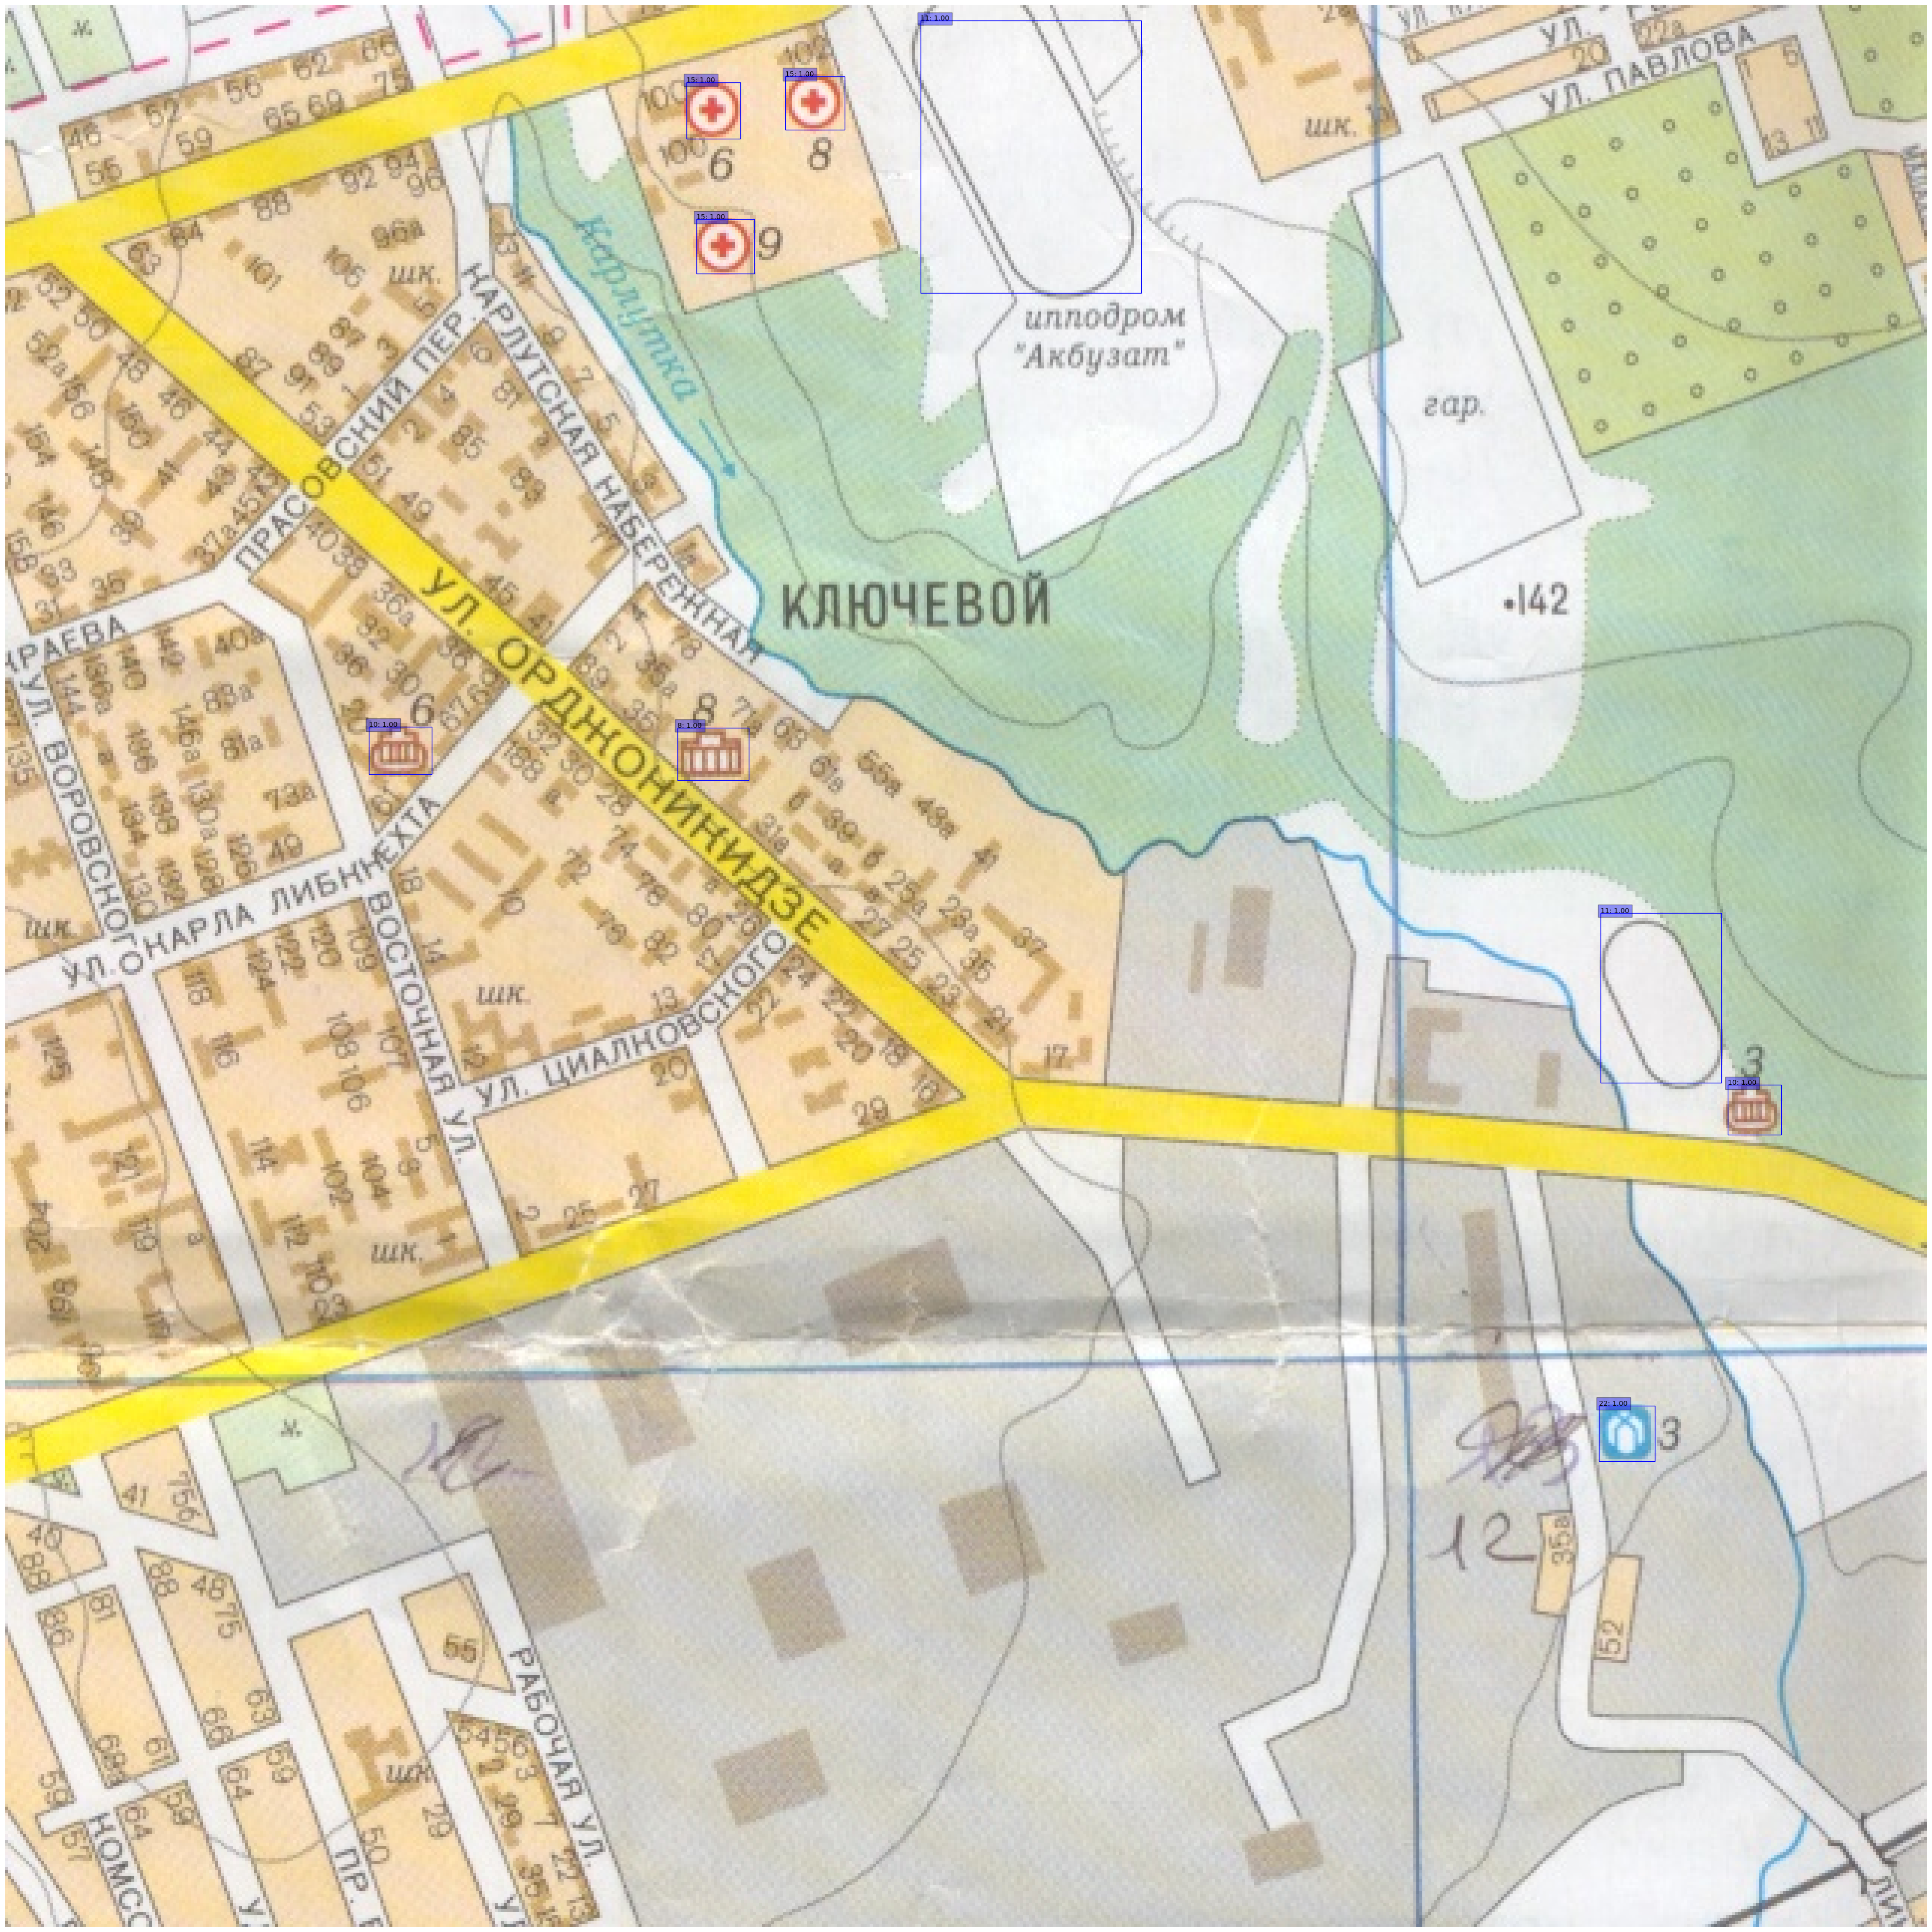

<Axes: >

In [48]:
import numpy as np
visualize_detections(img,predictions[0]['boxes'].detach().numpy(),predictions[0]['labels'].detach().numpy(),predictions[0]['scores'].detach().numpy())